## Libraries

In [195]:
import pandas as pd 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.log import EventLog
from collections import Counter
import pm4py
import matplotlib.pyplot as plt 
from pm4py.statistics.traces.log import case_statistics
from pm4py import stats

## connection to Neo4J database

In [175]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Neo4J1234"))
session = driver.session()

## Get cases from the graph database

In [176]:
query = f'''Match (e:Event) 
where e.CaseID is not null
return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,e.CaseID,e.Activity,e.Nombre,e.KitID,resource,e.timestamp,e.`Código`,e.NS
0,HNB-OFT.010-8-CN16357,Entrada Material Sucio,Parpados 08,HNB-OFT.010-8,VA,2022-03-31 12:39:00+00:00,HNB-OFT.010,8
1,HUBU-TR.008-1-CN16358,Entrada Material Sucio,Motores Linvatec Baterias 01,HUBU-TR.008-1,VA,2022-03-31 12:39:00+00:00,HUBU-TR.008,1
2,HUBU-TR.012-1-CN16359,Entrada Material Sucio,Motores Linvatec Electricos 01,HUBU-TR.012-1,VA,2022-03-31 12:38:00+00:00,HUBU-TR.012,1
3,HNB-CV.008-1-CN16360,Entrada Material Sucio,Amputación 01,HNB-CV.008-1,VA,2022-03-31 12:38:00+00:00,HNB-CV.008,1
4,HNB-CG.001-12-CN16361,Entrada Material Sucio,Laparotomia 12,HNB-CG.001-12,VA,2022-03-31 12:38:00+00:00,HNB-CG.001,12


## Start process discovery using PM4PY

### 1- Process discovery over the data without filters

In [177]:
event_log = pm4py.format_dataframe(df, case_id='e.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
event_log = pm4py.convert_to_event_log(event_log)

In [178]:
len(pm4py.get_variants_as_tuples(event_log))

2145

In [179]:
pm4py.get_start_activities(event_log)


{'Montaje': 4912,
 'Entrada Material Sucio': 12864,
 'Cargado en carro L+D': 929,
 'Comisionado': 165,
 'Carga L+D liberada': 41,
 'Carga de esterilizador liberada': 110,
 'Composición de cargas': 77,
 'Carga L+D iniciada': 122}

In [180]:
pm4py.get_end_activities(event_log)

{'Cargado en carro L+D': 75,
 'Carga L+D liberada': 2664,
 'Entrada Material Sucio': 1055,
 'Carga L+D iniciada': 145,
 'Comisionado': 10509,
 'Carga de esterilizador liberada': 4625,
 'Composición de cargas': 69,
 'Montaje': 32,
 'Producción montada': 46}

In [197]:
arrival_rate = stats.get_case_arrival_average(event_log) 
print("Average arrival rate in minutes:", arrival_rate / 60)

Average arrival rate: 6.710078568083667


In [198]:
median_case_duration = case_statistics.get_median_case_duration(event_log) 
print ('median_case_duration in minutes:', median_case_duration / 60)

median_case_duration in minutes: 310.0


In [186]:
variant_statistics = case_statistics.get_variant_statistics(event_log) 
variant_statistics

[{'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Comisionado'),
  'count': 3684},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada',
   'Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada'),
  'count': 3069},
 {'variant': ('Montaje',
   'Producción montada',
   'Composición de cargas',
   'Carga de esterilizador liberada',
   'Comisionado'),
  'count': 2135},
 {'variant': ('Entrada Material Sucio',
   'Cargado en carro L+D',
   'Carga L+D iniciada',
   'Carga L+D liberada'),
  'count': 1923},
 {'variant': ('Entrada Material Sucio',), 'count': 951},
 {'variant': ('Montaje',
   'Producción montada',
   'Producción montada',
   'Composición de cargas',
   'Composición de cargas',
   'Carga de esteriliza

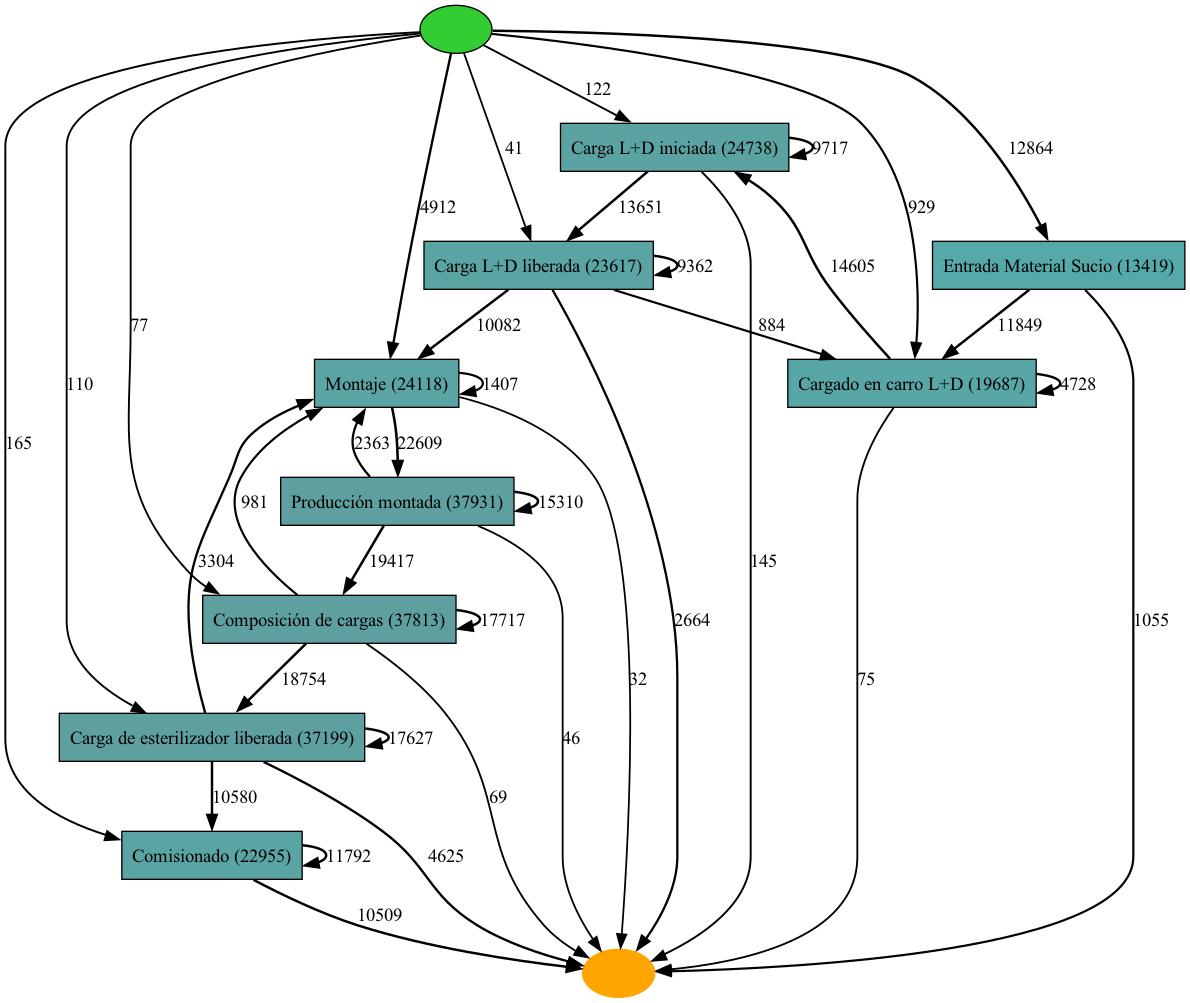

In [130]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

### 2- Process discovery over the data with filter on the frequency of the trace

In [131]:
# Calculate trace frequencies
trace_frequency = Counter()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    trace_frequency[trace_id] += 1

In [132]:
# Define the minimum frequency threshold
min_frequency = 10  # Change this value to your desired minimum frequency

# Filter traces based on frequency
filtered_event_log = EventLog()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    if trace_frequency[trace_id] >= min_frequency:
        filtered_event_log.append(trace)

In [133]:
len(pm4py.get_variants_as_tuples(filtered_event_log))

100

In [134]:
pm4py.get_start_activities(filtered_event_log)

{'Entrada Material Sucio': 12085,
 'Cargado en carro L+D': 346,
 'Comisionado': 104,
 'Montaje': 3683,
 'Carga de esterilizador liberada': 74,
 'Composición de cargas': 44}

In [135]:
pm4py.get_end_activities(filtered_event_log)

{'Carga L+D liberada': 2459,
 'Entrada Material Sucio': 1027,
 'Carga L+D iniciada': 98,
 'Cargado en carro L+D': 44,
 'Comisionado': 8733,
 'Carga de esterilizador liberada': 3930,
 'Composición de cargas': 29,
 'Producción montada': 16}

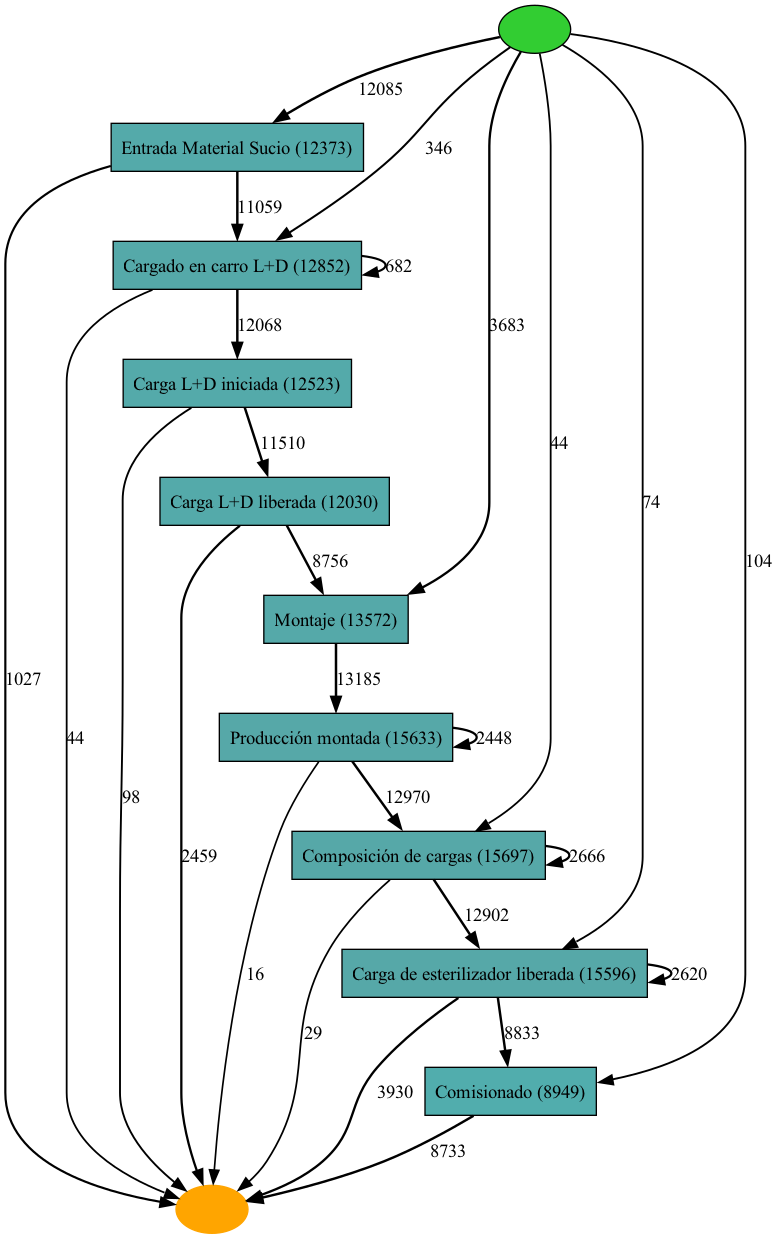

In [136]:
heu_net = pm4py.discover_heuristics_net(filtered_event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

## Statistics about the process flow

In [137]:
filtered_df = pm4py.convert_to_dataframe(filtered_event_log)
filtered_df.head()

,concept:name,e.Nombre,e.KitID,resource,time:timestamp,e.`Código`,e.NS,@@index,case:concept:name
0,Entrada Material Sucio,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:21:00+00:00,CONT-CCEE.ALE,1,6316,CONT-CCEE.ALE-1-CN10693
1,Cargado en carro L+D,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1,21163,CONT-CCEE.ALE-1-CN10693
2,Carga L+D iniciada,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1,42138,CONT-CCEE.ALE-1-CN10693
3,Carga L+D liberada,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,SM,2022-02-22 15:06:00+00:00,CONT-CCEE.ALE,1,66470,CONT-CCEE.ALE-1-CN10693
4,Entrada Material Sucio,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:26:00+00:00,CONT-CCEE.ALE,1,5919,CONT-CCEE.ALE-1-CN11313


In [138]:
segments = []
df = filtered_df.sort_values(['case:concept:name', 'time:timestamp', 'concept:name'])

result = pd.concat([df, df.shift(-1)], axis=1)
result.columns = [str(i) + str(k // (len(df.columns))) for k, i in enumerate(result.columns)]
result = result[result['case:concept:name0'] == result['case:concept:name1']]

result['segment_name'] = result['concept:name0'] + ' - ' + result['concept:name1']
result.drop(['concept:name0', 'case:concept:name1', 'concept:name1'], axis=1, inplace=True)
result.columns = ['start_' + i.split('0')[0] if '0' in i else ('end_' + i.split('1')[0] if '1' in i else i) for i in result.columns]

segments = result['segment_name'].unique()
result.head()

,start_e.Nombre,start_e.KitID,start_resource,start_time:timestamp,start_e.`Código`,start_e.NS,start_@@index,start_case:concept:name,end_e.Nombre,end_e.KitID,end_resource,end_time:timestamp,end_e.`Código`,end_e.NS,end_@@index,segment_name
0,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:21:00+00:00,CONT-CCEE.ALE,1,6316,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1.0,21163.0,Entrada Material Sucio - Cargado en carro L+D
1,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1,21163,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1.0,42138.0,Cargado en carro L+D - Carga L+D iniciada
2,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1,42138,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,SM,2022-02-22 15:06:00+00:00,CONT-CCEE.ALE,1.0,66470.0,Carga L+D iniciada - Carga L+D liberada
4,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:26:00+00:00,CONT-CCEE.ALE,1,5919,CONT-CCEE.ALE-1-CN11313,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:49:00+00:00,CONT-CCEE.ALE,1.0,20657.0,Entrada Material Sucio - Cargado en carro L+D
5,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:49:00+00:00,CONT-CCEE.ALE,1,20657,CONT-CCEE.ALE-1-CN11313,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,EH,2022-02-24 13:51:00+00:00,CONT-CCEE.ALE,1.0,41533.0,Cargado en carro L+D - Carga L+D iniciada


### 1- Over all statistics

In [ ]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 

In [164]:
# Calculate Q1, Q3, and IQR
Q1 = result.groupby('segment_name')['durationMinutes'].quantile(0.25)
Q3 = result.groupby('segment_name')['durationMinutes'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
result_filtered = result[~result.apply(lambda x: (x['durationMinutes'] < lower_bound[x['segment_name']]) or 
                                              (x['durationMinutes'] > upper_bound[x['segment_name']]), axis=1)]

# Group by segment_name and calculate statistics
grouped = result_filtered.groupby('segment_name')['durationMinutes'].describe()

print(grouped)

                                                      count          mean  \
segment_name                                                                
Carga L+D iniciada - Carga L+D iniciada               337.0     20.415430   
Carga L+D iniciada - Carga L+D liberada              9578.0     69.288578   
Carga L+D iniciada - Cargado en carro L+D             920.0      0.000000   
Carga L+D iniciada - Montaje                           54.0     18.722222   
Carga L+D liberada - Carga L+D iniciada                63.0    643.412698   
Carga L+D liberada - Carga L+D liberada               384.0     31.429688   
Carga L+D liberada - Cargado en carro L+D             314.0   2525.461783   
Carga L+D liberada - Composición de cargas             22.0     13.727273   
Carga L+D liberada - Montaje                         8208.0     26.785575   
Carga de esterilizador liberada - Carga L+D ini...     28.0   1748.357143   
Carga de esterilizador liberada - Carga de este...   2613.0      0.000000   

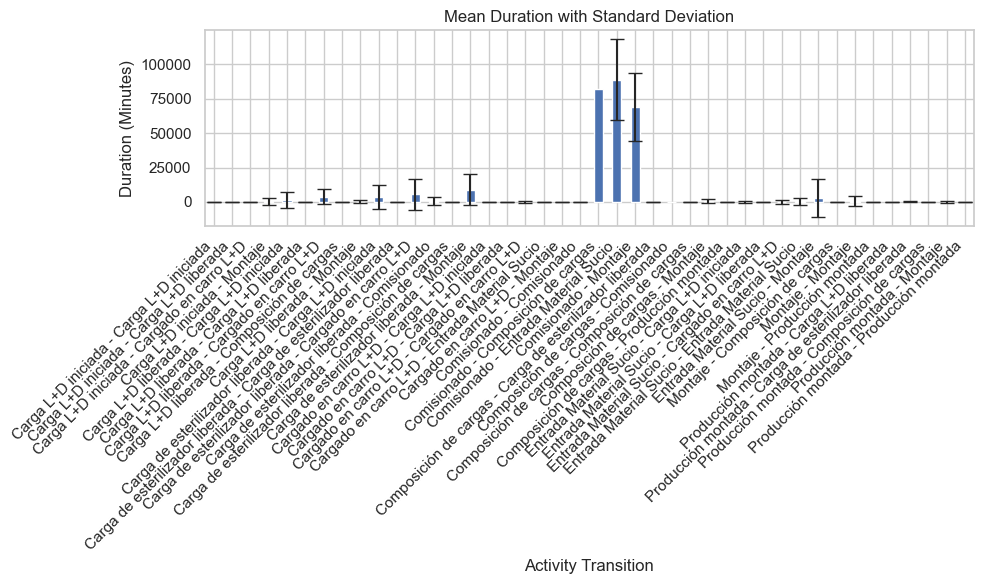

In [139]:
result['durationMinutes'] = (result['end_time:timestamp'] - result['start_time:timestamp']).dt.total_seconds() / 60 
grouped = result.groupby(['segment_name'])['durationMinutes'].describe()

# Plotting mean with error bars (standard deviation)
plt.figure(figsize=(10, 6))
grouped['mean'].plot(kind='bar', yerr=grouped['std'], capsize=5)
plt.xlabel('Activity Transition')
plt.ylabel('Duration (Minutes)')
plt.title('Mean Duration with Standard Deviation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [140]:
result.head()

,start_e.Nombre,start_e.KitID,start_resource,start_time:timestamp,start_e.`Código`,start_e.NS,start_@@index,start_case:concept:name,end_e.Nombre,end_e.KitID,end_resource,end_time:timestamp,end_e.`Código`,end_e.NS,end_@@index,segment_name,durationMinutes
0,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:21:00+00:00,CONT-CCEE.ALE,1,6316,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1.0,21163.0,Entrada Material Sucio - Cargado en carro L+D,7.0
1,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1,21163,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1.0,42138.0,Cargado en carro L+D - Carga L+D iniciada,29.0
2,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1,42138,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,SM,2022-02-22 15:06:00+00:00,CONT-CCEE.ALE,1.0,66470.0,Carga L+D iniciada - Carga L+D liberada,69.0
4,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:26:00+00:00,CONT-CCEE.ALE,1,5919,CONT-CCEE.ALE-1-CN11313,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:49:00+00:00,CONT-CCEE.ALE,1.0,20657.0,Entrada Material Sucio - Cargado en carro L+D,23.0
5,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:49:00+00:00,CONT-CCEE.ALE,1,20657,CONT-CCEE.ALE-1-CN11313,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,EH,2022-02-24 13:51:00+00:00,CONT-CCEE.ALE,1.0,41533.0,Cargado en carro L+D - Carga L+D iniciada,2.0


In [141]:
grouped.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,364.0,29.873626,41.686690,0.0,3.0,12.5,38.0,195.0
Carga L+D iniciada - Carga L+D liberada,10846.0,83.508943,84.573927,0.0,63.0,70.0,77.0,826.0
Carga L+D iniciada - Cargado en carro L+D,1158.0,5.842832,29.747328,0.0,0.0,0.0,0.0,603.0
Carga L+D iniciada - Montaje,61.0,388.213115,2587.745512,1.0,5.0,12.0,39.0,20186.0
Carga L+D liberada - Carga L+D iniciada,66.0,1547.106061,5917.214049,1.0,11.0,124.0,1336.0,47311.0


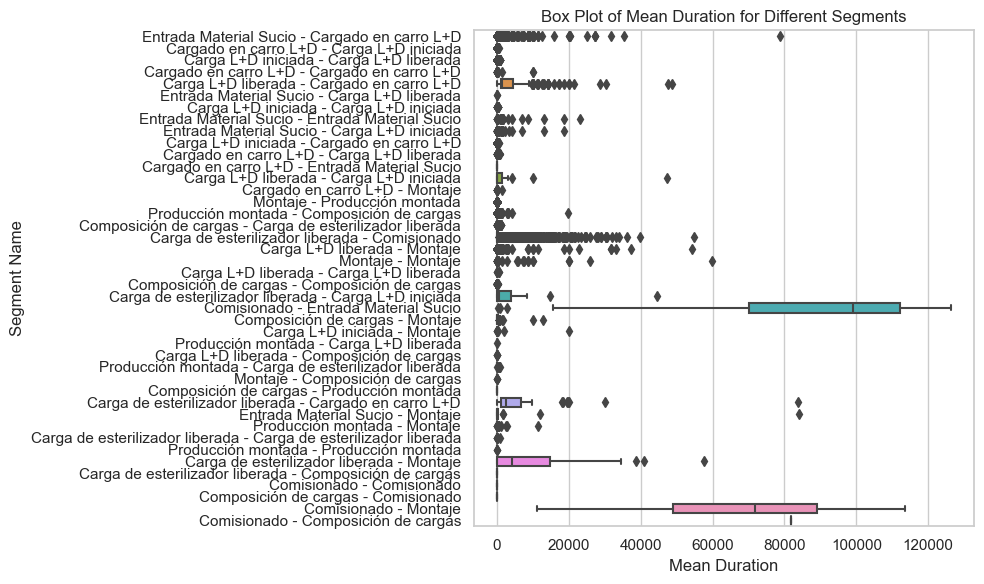

In [142]:
sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=result['durationMinutes'], y=result['segment_name'], showfliers=True)
plt.xlabel('Mean Duration')
plt.ylabel('Segment Name')
plt.title('Box Plot of Mean Duration for Different Segments')
plt.tight_layout()
plt.show()

### 2- add frequency filter, to filter incidences less that 100 time

In [143]:
freq = grouped[grouped['count'] > 100]
freq.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,364.0,29.873626,41.686690,0.0,3.0,12.5,38.0,195.0
Carga L+D iniciada - Carga L+D liberada,10846.0,83.508943,84.573927,0.0,63.0,70.0,77.0,826.0
Carga L+D iniciada - Cargado en carro L+D,1158.0,5.842832,29.747328,0.0,0.0,0.0,0.0,603.0
Carga L+D liberada - Carga L+D liberada,389.0,35.241645,49.302017,0.0,13.0,29.0,49.0,640.0
Carga L+D liberada - Cargado en carro L+D,344.0,3785.177326,5542.500388,0.0,1155.0,1380.0,4398.0,48731.0


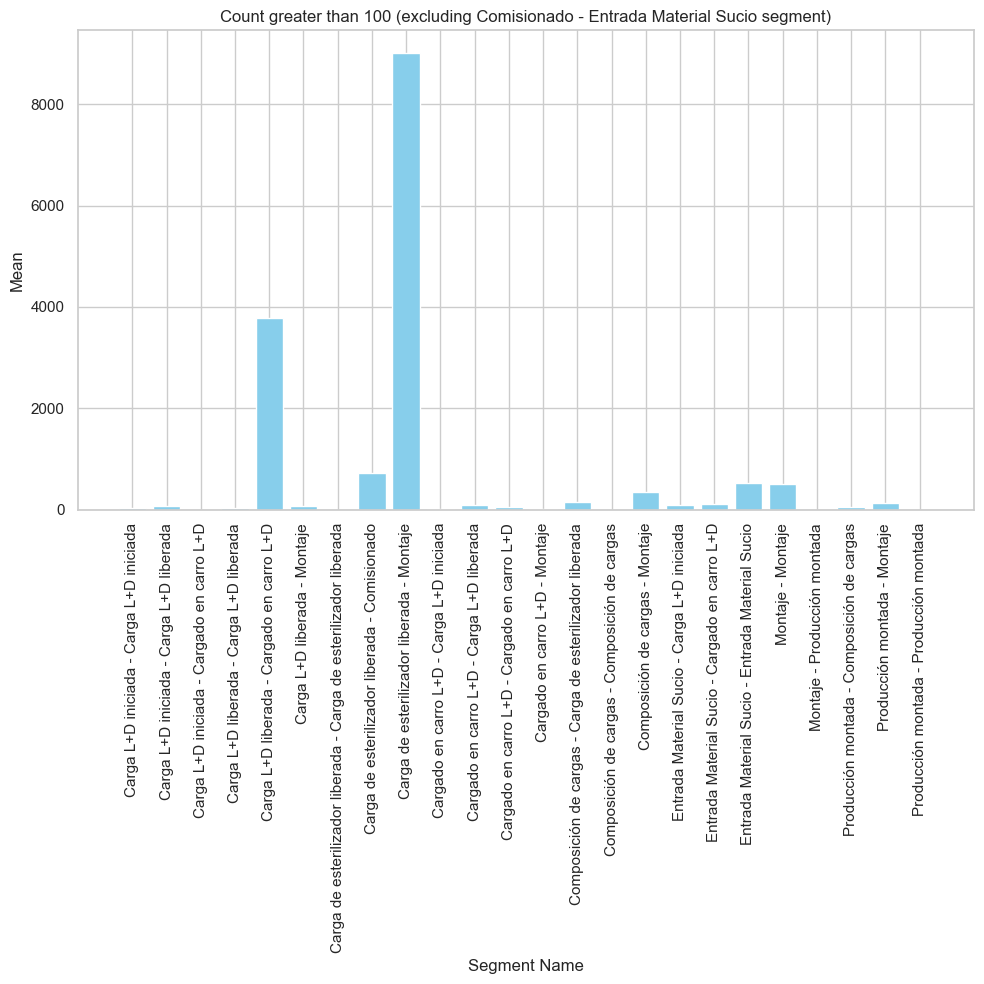

In [144]:
# Exclude a single segment by specifying its index or label
segment_to_exclude = 'Comisionado - Entrada Material Sucio'

# Filter the DataFrame to include only segments other than the one to exclude
filtered_df_excluded = freq[freq.index != segment_to_exclude]

# Plot the filtered data excluding the single segment
plt.figure(figsize=(10, 10))
plt.bar(filtered_df_excluded.index, filtered_df_excluded['mean'], color='skyblue')
plt.xlabel('Segment Name')
plt.ylabel('Mean')
plt.title('Count greater than 100 (excluding Comisionado - Entrada Material Sucio segment)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### 3- Plot the data including a specified segments

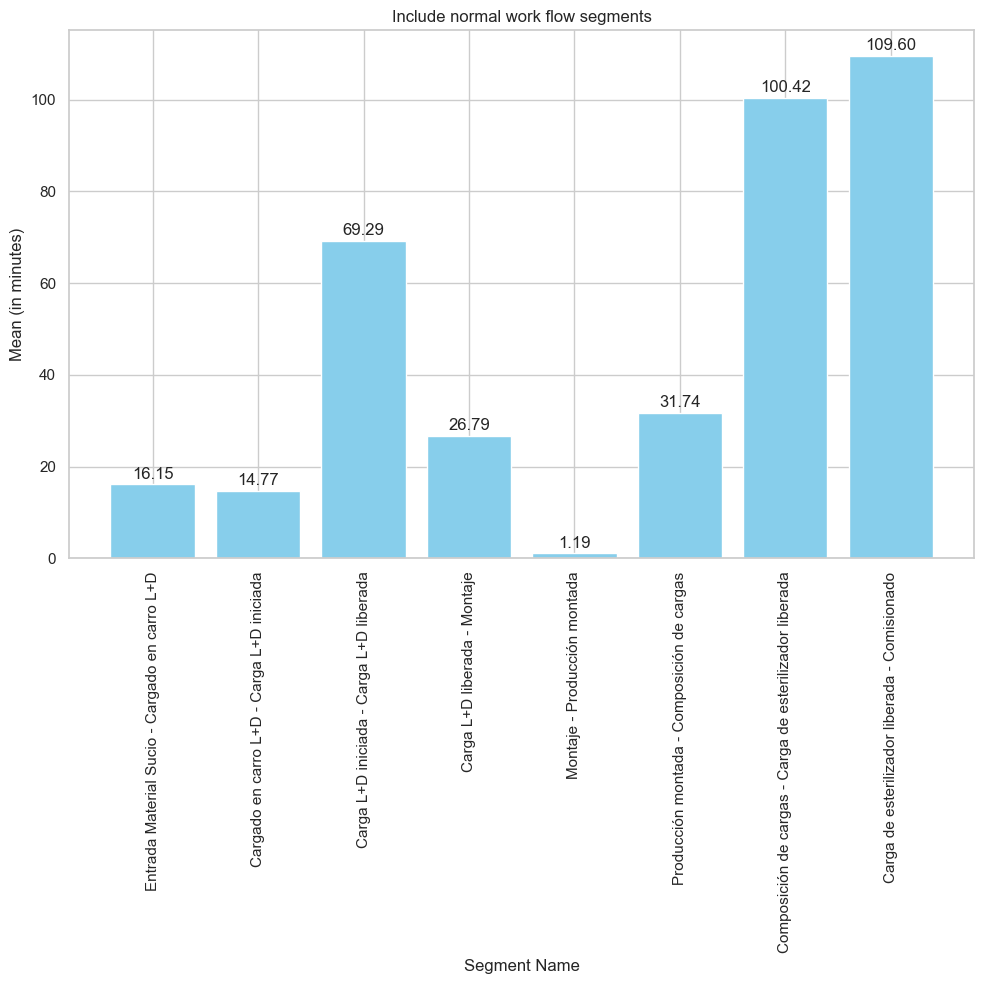

In [165]:
# Define the segments to include
segments_work_flow = ['Entrada Material Sucio - Cargado en carro L+D',
                        'Cargado en carro L+D - Carga L+D iniciada',
                         'Carga L+D iniciada - Carga L+D liberada',
                          'Carga L+D liberada - Montaje',
                           'Montaje - Producción montada',
                            'Producción montada - Composición de cargas',
                             'Composición de cargas - Carga de esterilizador liberada',
                              'Carga de esterilizador liberada - Comisionado']

filtered_df_included = grouped[grouped.index.isin(segments_work_flow)]
filtered_df_included = filtered_df_included.loc[segments_work_flow]

plt.figure(figsize=(10, 10))
bars = plt.bar(filtered_df_included.index, filtered_df_included['mean'], color='skyblue')

for bar, mean in zip(bars, filtered_df_included['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{mean:.2f}', ha='center', va='bottom')

plt.xlabel('Segment Name')
plt.ylabel('Mean (in minutes)')
plt.title('Include normal work flow segments')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [169]:
filtered_df_included.head(10)

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Entrada Material Sucio - Cargado en carro L+D,9608.0,16.148626,9.574826,1.0,9.0,14.0,22.0,46.0
Cargado en carro L+D - Carga L+D iniciada,10639.0,14.773381,15.030071,1.0,2.0,9.0,24.0,62.0
Carga L+D iniciada - Carga L+D liberada,9578.0,69.288578,9.654945,43.0,63.0,69.0,75.0,97.0
Carga L+D liberada - Montaje,8208.0,26.785575,22.634913,0.0,9.0,20.0,39.0,97.0
Montaje - Producción montada,12053.0,1.185514,1.810771,0.0,0.0,0.0,2.0,7.0
Producción montada - Composición de cargas,12003.0,31.739482,27.875378,1.0,10.0,23.0,46.0,121.0
Composición de cargas - Carga de esterilizador liberada,11627.0,100.423841,20.396220,41.0,85.0,100.0,113.0,161.0
Carga de esterilizador liberada - Comisionado,7802.0,109.598949,132.241512,0.0,15.0,45.0,169.0,627.0


In [173]:
total_row = filtered_df_included.sum(axis=0)
total_row['segment_name'] = 'Total'

# Append the total row to the DataFrame
df_with_total = filtered_df_included.append(total_row, ignore_index=True)

df_with_total.head(10)

,count,mean,std,min,25%,50%,75%,max,segment_name
0,9608.0,16.148626,9.574826,1.0,9.0,14.0,22.0,46.0,NaN
1,10639.0,14.773381,15.030071,1.0,2.0,9.0,24.0,62.0,NaN
2,9578.0,69.288578,9.654945,43.0,63.0,69.0,75.0,97.0,NaN
3,8208.0,26.785575,22.634913,0.0,9.0,20.0,39.0,97.0,NaN
4,12053.0,1.185514,1.810771,0.0,0.0,0.0,2.0,7.0,NaN
5,12003.0,31.739482,27.875378,1.0,10.0,23.0,46.0,121.0,NaN
6,11627.0,100.423841,20.396220,41.0,85.0,100.0,113.0,161.0,NaN
7,7802.0,109.598949,132.241512,0.0,15.0,45.0,169.0,627.0,NaN
8,81518.0,369.943946,239.218636,87.0,193.0,280.0,490.0,1218.0,Total


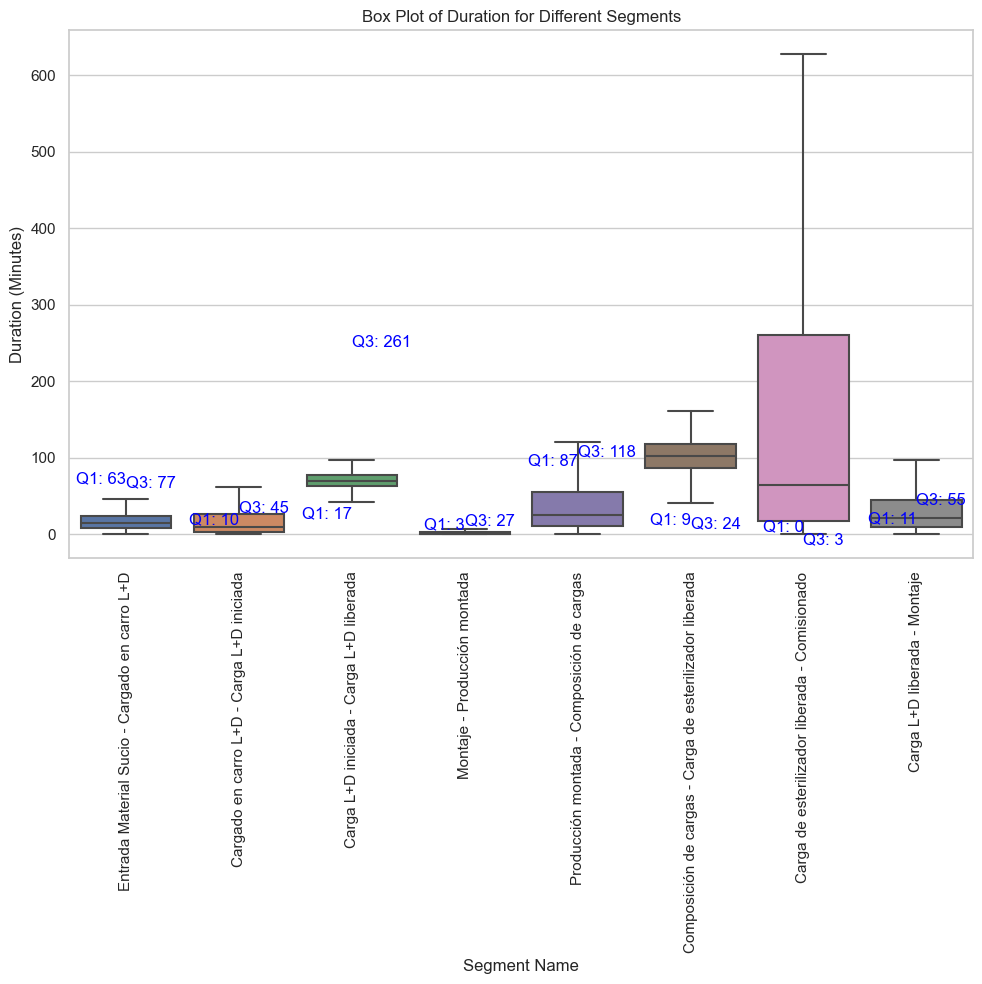

In [147]:
filtered_data = result[result['segment_name'].isin(segments_work_flow)]

# Calculate statistics
grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')

# Add standard deviation (std), 25th percentile (Q1), and 75th percentile (Q3) annotations
for i in range(len(statistics)):
    segment_name = statistics.loc[i, 'segment_name']
    #std = statistics.loc[i, 'std']
    q1 = statistics.loc[i, '25%']
    q3 = statistics.loc[i, '75%']
    plt.text(i, q1, f'Q1: {q1:.0f}', ha='right', va='bottom', color='blue')
    plt.text(i, q3, f'Q3: {q3:.0f}', ha='left', va='top', color='blue')
    #plt.text(i, q1 - 0.5*std, f'Std: {std:.0f}', ha='center', va='top', color='red')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [148]:
filtered_data.head()

,start_e.Nombre,start_e.KitID,start_resource,start_time:timestamp,start_e.`Código`,start_e.NS,start_@@index,start_case:concept:name,end_e.Nombre,end_e.KitID,end_resource,end_time:timestamp,end_e.`Código`,end_e.NS,end_@@index,segment_name,durationMinutes
0,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:21:00+00:00,CONT-CCEE.ALE,1,6316,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1.0,21163.0,Entrada Material Sucio - Cargado en carro L+D,7.0
1,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,LI,2022-02-22 13:28:00+00:00,CONT-CCEE.ALE,1,21163,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1.0,42138.0,Cargado en carro L+D - Carga L+D iniciada,29.0
2,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,MR,2022-02-22 13:57:00+00:00,CONT-CCEE.ALE,1,42138,CONT-CCEE.ALE-1-CN10693,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,SM,2022-02-22 15:06:00+00:00,CONT-CCEE.ALE,1.0,66470.0,Carga L+D iniciada - Carga L+D liberada,69.0
4,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:26:00+00:00,CONT-CCEE.ALE,1,5919,CONT-CCEE.ALE-1-CN11313,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:49:00+00:00,CONT-CCEE.ALE,1.0,20657.0,Entrada Material Sucio - Cargado en carro L+D,23.0
5,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,PG,2022-02-24 13:49:00+00:00,CONT-CCEE.ALE,1,20657,CONT-CCEE.ALE-1-CN11313,*CCEE ALERGIAS 1B,CONT-CCEE.ALE-1,EH,2022-02-24 13:51:00+00:00,CONT-CCEE.ALE,1.0,41533.0,Cargado en carro L+D - Carga L+D iniciada,2.0


### 4- Plot the data including tasks skipping one in between

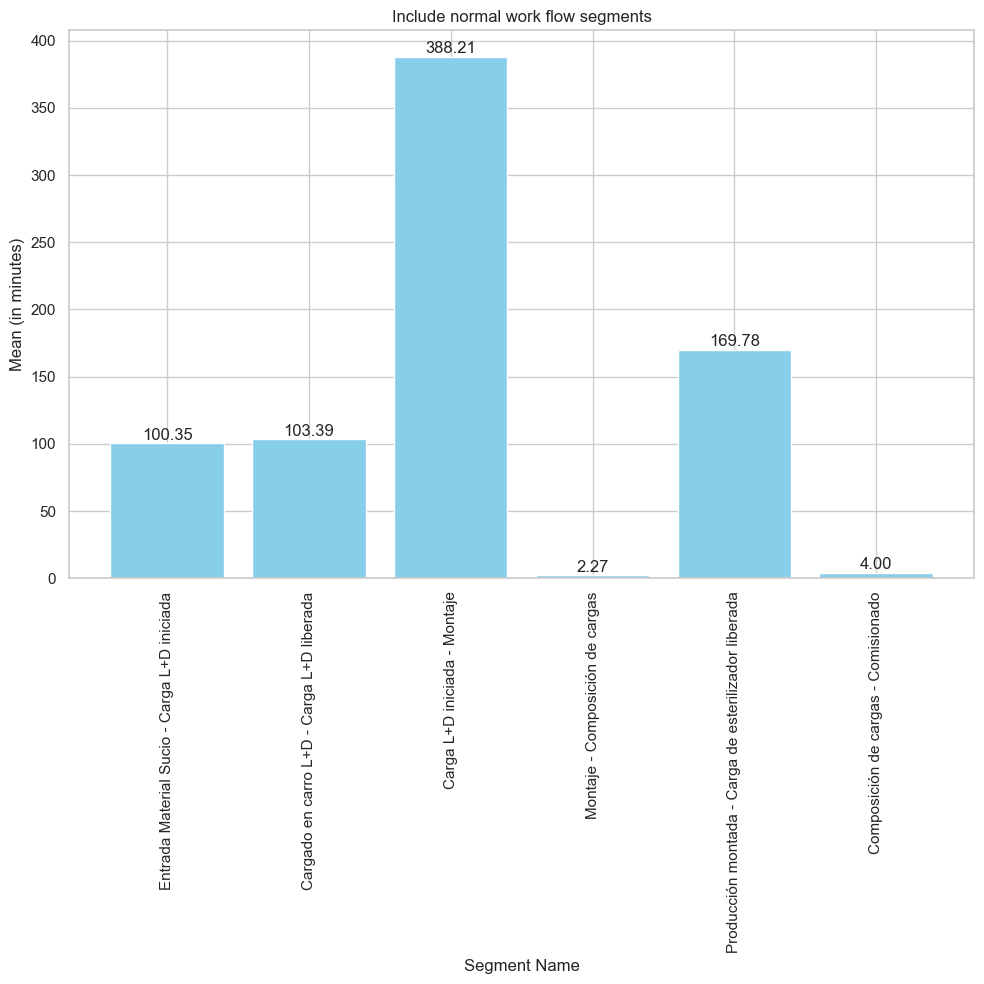

In [149]:
# Define the segments to include
segments_to_include = ['Entrada Material Sucio - Carga L+D iniciada',
                        'Cargado en carro L+D - Carga L+D liberada',
                         'Carga L+D iniciada - Montaje',
                           'Montaje - Composición de cargas',
                            'Producción montada - Carga de esterilizador liberada',
                             'Composición de cargas - Comisionado']

filtered_df_included = grouped[grouped.index.isin(segments_to_include)]
filtered_df_included = filtered_df_included.loc[segments_to_include]

plt.figure(figsize=(10, 10))
bars = plt.bar(filtered_df_included.index, filtered_df_included['mean'], color='skyblue')

for bar, mean in zip(bars, filtered_df_included['mean']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{mean:.2f}', ha='center', va='bottom')

plt.xlabel('Segment Name')
plt.ylabel('Mean (in minutes)')
plt.title('Include normal work flow segments')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In [150]:
filtered_df_included.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Entrada Material Sucio - Carga L+D iniciada,774.0,100.348837,889.288608,1.0,6.00,13.0,21.00,18738.0
Cargado en carro L+D - Carga L+D liberada,720.0,103.388889,133.745493,1.0,59.00,70.0,80.00,762.0
Carga L+D iniciada - Montaje,61.0,388.213115,2587.745512,1.0,5.00,12.0,39.00,20186.0
Montaje - Composición de cargas,22.0,2.272727,2.394076,1.0,1.00,1.0,2.00,10.0
Producción montada - Carga de esterilizador liberada,54.0,169.777778,202.556926,4.0,75.25,90.0,115.75,901.0


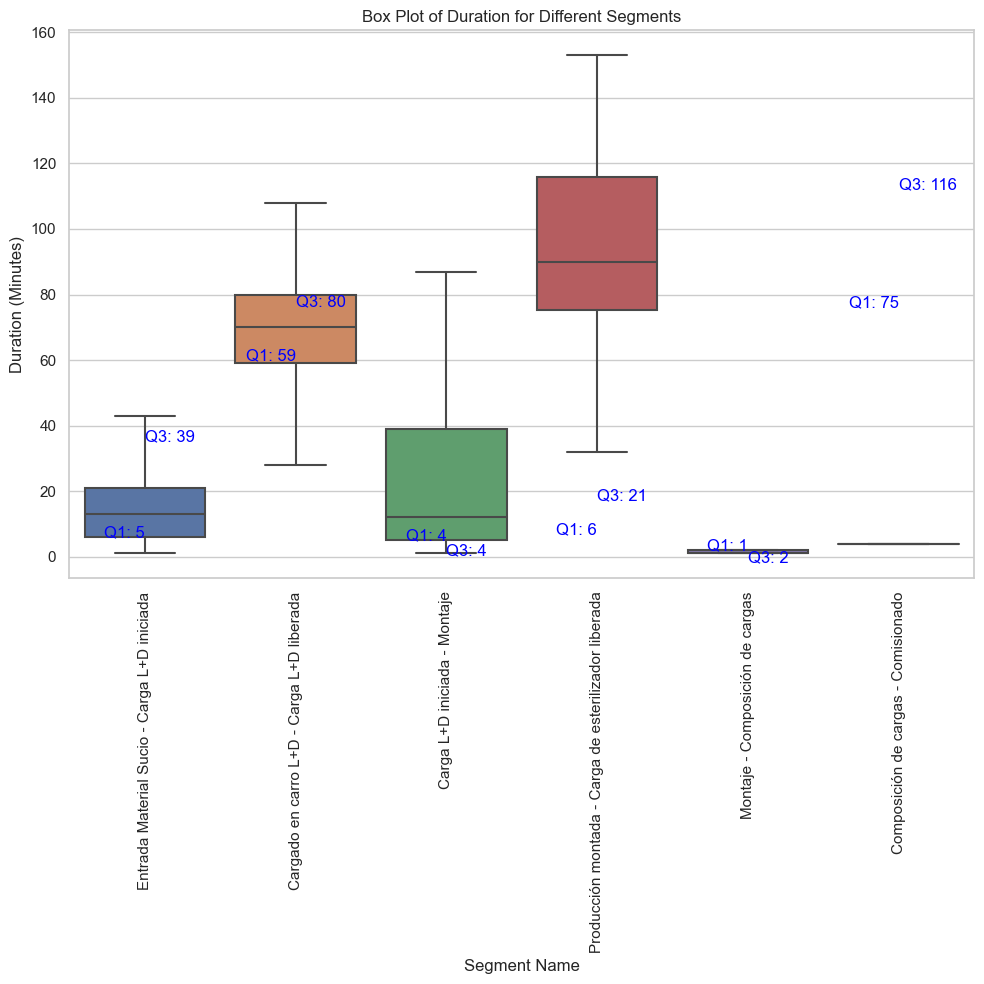

In [151]:
filtered_data = result[result['segment_name'].isin(segments_to_include)]

# Calculate statistics
grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')

# Add standard deviation (std), 25th percentile (Q1), and 75th percentile (Q3) annotations
for i in range(len(statistics)):
    segment_name = statistics.loc[i, 'segment_name']
    #std = statistics.loc[i, 'std']
    q1 = statistics.loc[i, '25%']
    q3 = statistics.loc[i, '75%']
    plt.text(i, q1, f'Q1: {q1:.0f}', ha='right', va='bottom', color='blue')
    plt.text(i, q3, f'Q3: {q3:.0f}', ha='left', va='top', color='blue')
    #plt.text(i, q1 - 0.5*std, f'Std: {std:.0f}', ha='center', va='top', color='red')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [152]:
statistics.head()

,segment_name,std,25%,75%
0,Carga L+D iniciada - Montaje,2587.745512,5.0,39.0
1,Cargado en carro L+D - Carga L+D liberada,133.745493,59.0,80.0
2,Composición de cargas - Comisionado,NaN,4.0,4.0
3,Entrada Material Sucio - Carga L+D iniciada,889.288608,6.0,21.0
4,Montaje - Composición de cargas,2.394076,1.0,2.0


### 5- Exclude the normal process flow

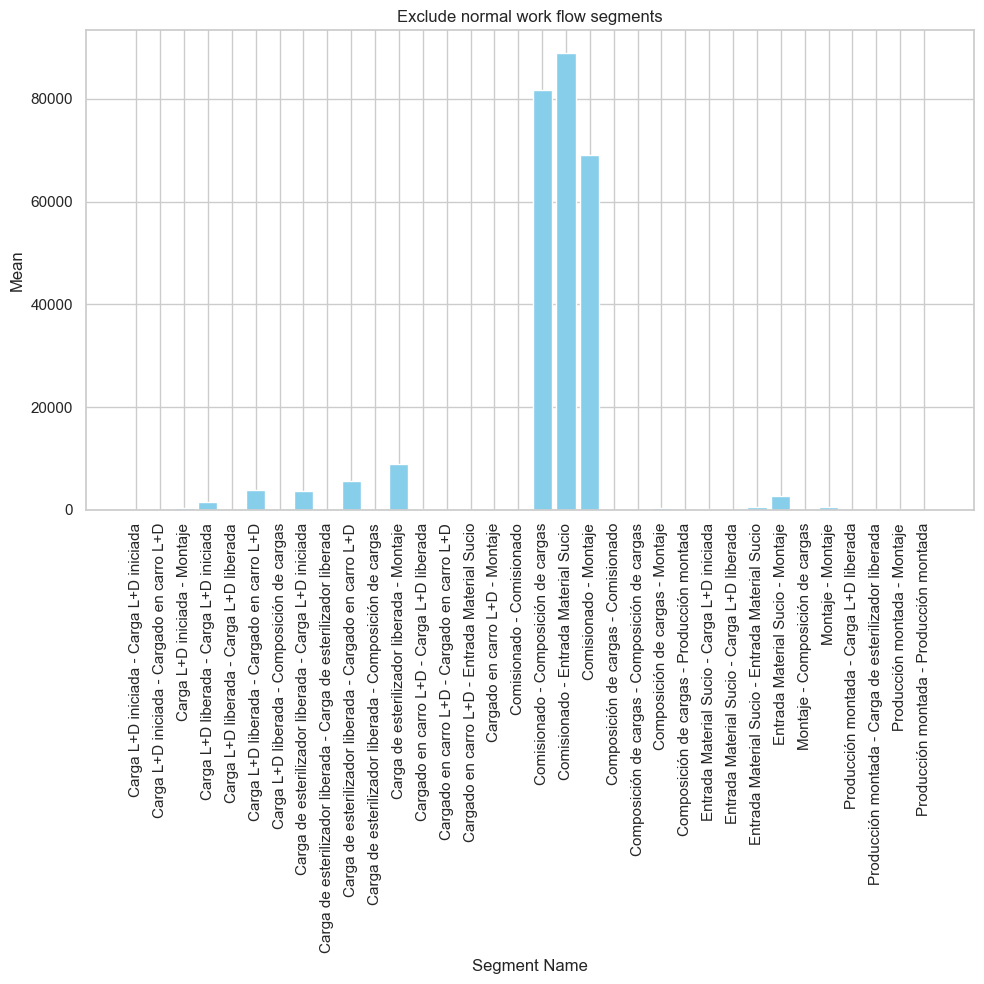

In [160]:
# Filter the DataFrame to include only segments not in the exclusion list
filtered_df_excluded = filtered_df[~filtered_df.index.isin(segments_work_flow)]

filtered_df_excluded = grouped[~grouped.index.isin(segments_work_flow)]

# Plot the filtered data excluding the specified segments
plt.figure(figsize=(10, 10))
plt.bar(filtered_df_excluded.index, filtered_df_excluded['mean'], color='skyblue')
plt.xlabel('Segment Name')
plt.ylabel('Mean')
plt.title('Exclude normal work flow segments')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [158]:
filtered_df_excluded.head()

,count,mean,std,min,25%,50%,75%,max
segment_name,,,,,,,,
Carga L+D iniciada - Carga L+D iniciada,364.0,29.873626,41.686690,0.0,3.0,12.5,38.0,195.0
Carga L+D iniciada - Cargado en carro L+D,1158.0,5.842832,29.747328,0.0,0.0,0.0,0.0,603.0
Carga L+D iniciada - Montaje,61.0,388.213115,2587.745512,1.0,5.0,12.0,39.0,20186.0
Carga L+D liberada - Carga L+D iniciada,66.0,1547.106061,5917.214049,1.0,11.0,124.0,1336.0,47311.0
Carga L+D liberada - Carga L+D liberada,389.0,35.241645,49.302017,0.0,13.0,29.0,49.0,640.0


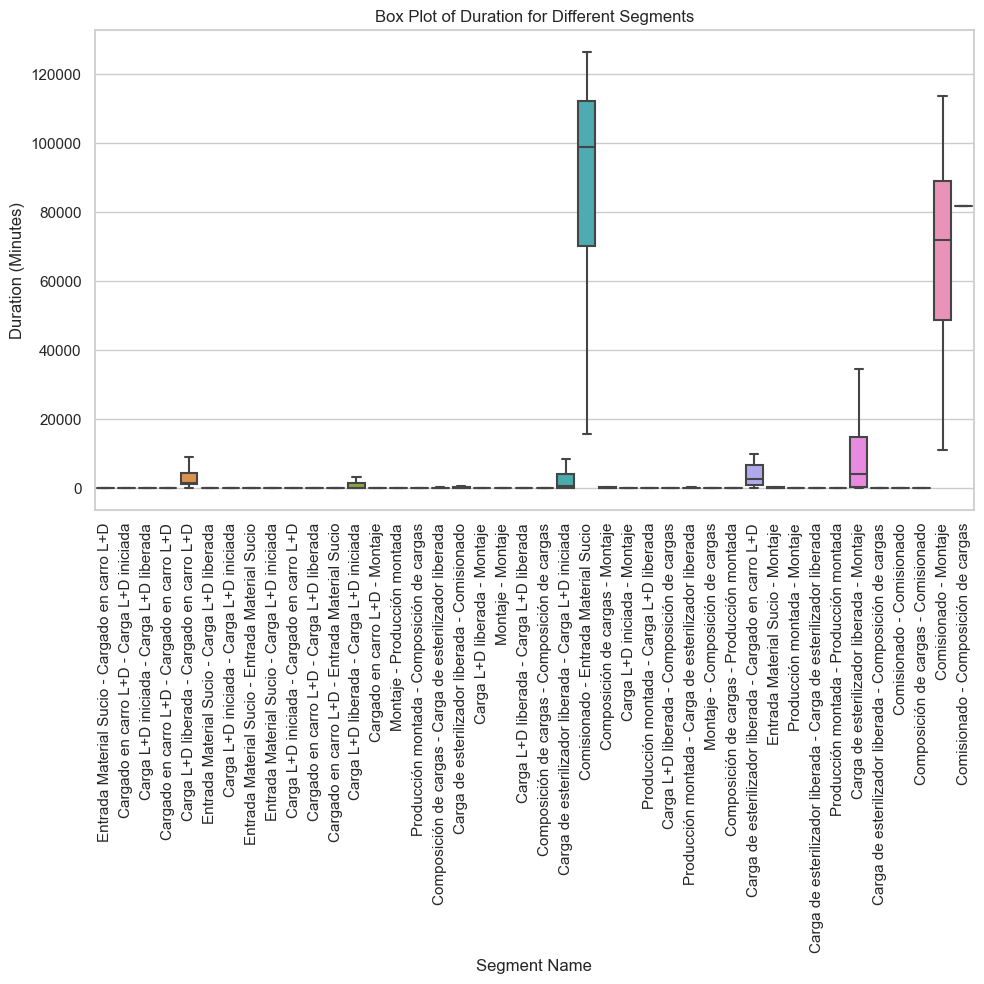

In [159]:
filtered_data = result[~result['segment_name'].isin(filtered_df_excluded)]

# Calculate statistics
grouped_data = filtered_data.groupby('segment_name')['durationMinutes']
statistics = grouped_data.describe(percentiles=[.25, .75])[['std', '25%', '75%']].reset_index()

sns.set(style="whitegrid")

# Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(x='segment_name', y='durationMinutes', data=filtered_data, showfliers= False)
plt.xlabel('Segment Name')
plt.ylabel('Duration (Minutes)')
plt.title('Box Plot of Duration for Different Segments')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [156]:
statistics.head()

,segment_name,std,25%,75%
0,Carga L+D iniciada - Carga L+D iniciada,41.686690,3.0,38.0
1,Carga L+D iniciada - Carga L+D liberada,84.573927,63.0,77.0
2,Carga L+D iniciada - Cargado en carro L+D,29.747328,0.0,0.0
3,Carga L+D iniciada - Montaje,2587.745512,5.0,39.0
4,Carga L+D liberada - Carga L+D iniciada,5917.214049,11.0,1336.0
